Scenario 1: PU and attacker inside the region


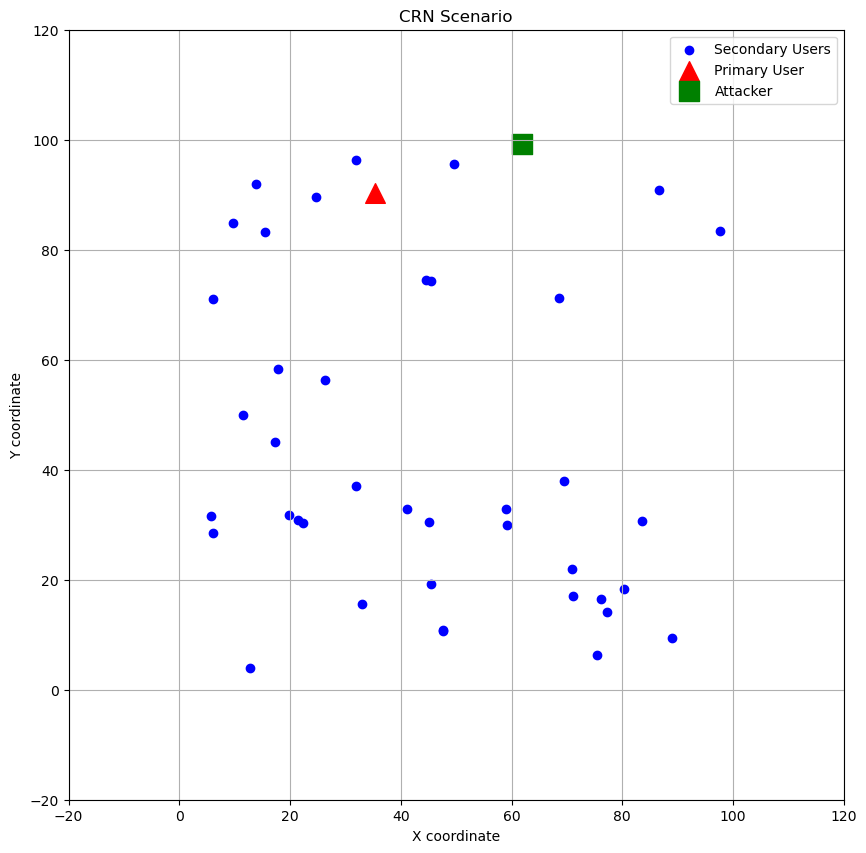


Confusion Matrix:
True Negatives (Genuine PU correctly identified): 2019
False Positives (Genuine PU incorrectly identified as attacker): 0
False Negatives (Attacker incorrectly identified as genuine PU): 0
True Positives (Attacker correctly identified): 1981

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2019
         1.0       1.00      1.00      1.00      1981

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



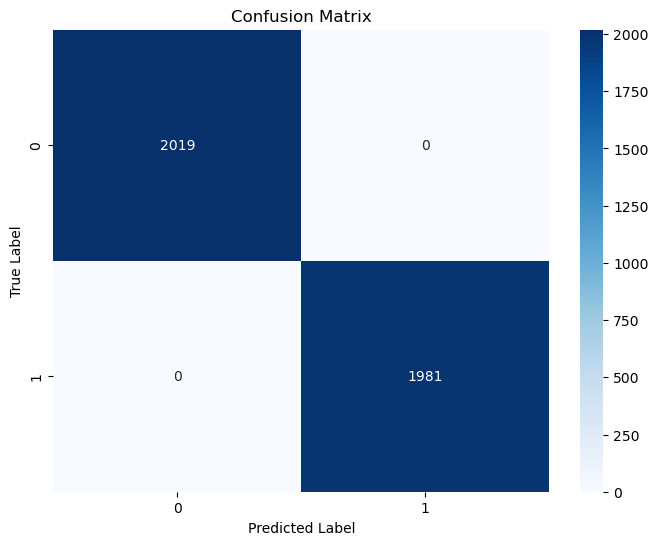


Scenario 2: PU and attacker outside the region


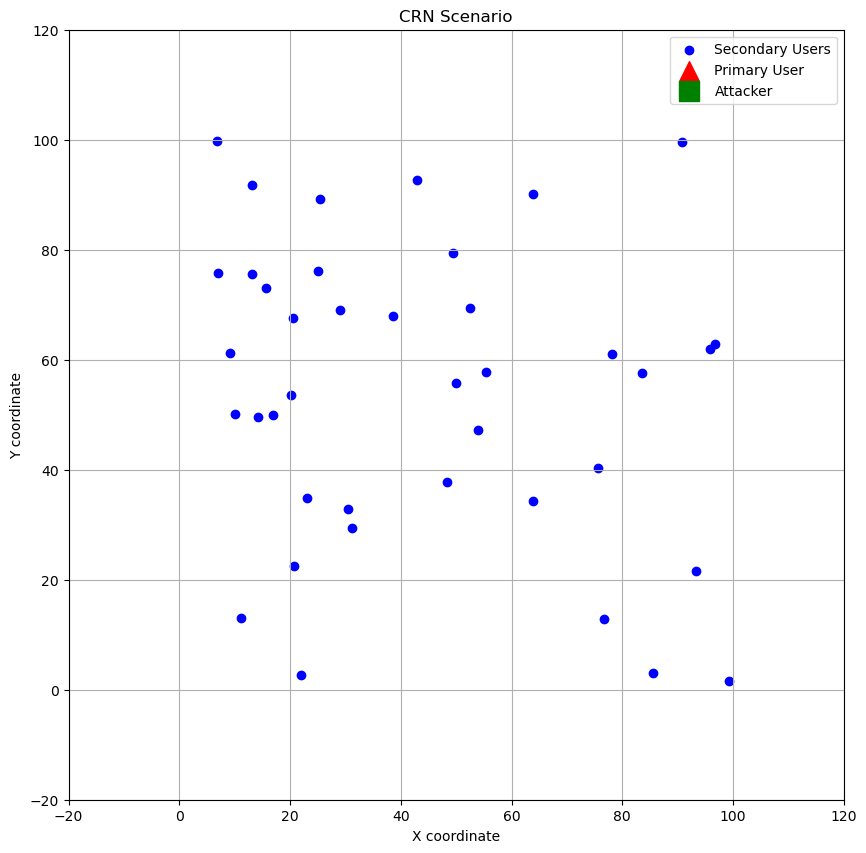


Confusion Matrix:
True Negatives (Genuine PU correctly identified): 981
False Positives (Genuine PU incorrectly identified as attacker): 1038
False Negatives (Attacker incorrectly identified as genuine PU): 985
True Positives (Attacker correctly identified): 996

Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.49      0.49      2019
         1.0       0.49      0.50      0.50      1981

    accuracy                           0.49      4000
   macro avg       0.49      0.49      0.49      4000
weighted avg       0.49      0.49      0.49      4000



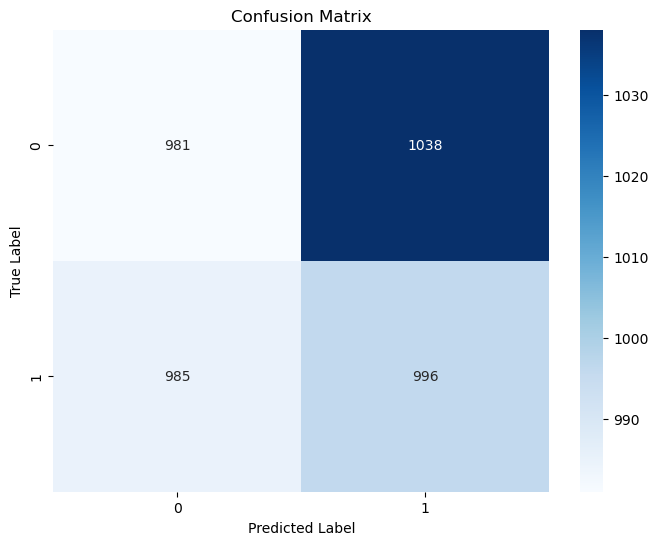

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class CRNSimulation:
    def __init__(self, num_sus=40, num_slots=10000, region_size=100):
        self.num_sus = num_sus
        self.num_slots = num_slots
        self.region_size = region_size
        self.su_locations = None
        self.pu_location = None
        self.attacker_location = None
        
    def generate_locations(self, scenario='inside'):
        """Generate random locations for SUs, PU, and attacker"""
        # Generate SU locations
        self.su_locations = np.random.uniform(0, self.region_size, size=(self.num_sus, 2))
        
        if scenario == 'inside':
            # PU and attacker inside the region
            self.pu_location = np.random.uniform(0, self.region_size, size=2)
            self.attacker_location = np.random.uniform(0, self.region_size, size=2)
        else:
            # PU and attacker outside the region
            self.pu_location = np.array([self.region_size * 1.5, self.region_size * 1.5])
            self.attacker_location = np.array([-self.region_size * 0.5, -self.region_size * 0.5])
    
    def plot_scenario(self):
        """Plot the current scenario"""
        plt.figure(figsize=(10, 10))
        plt.scatter(self.su_locations[:, 0], self.su_locations[:, 1], 
                   c='blue', label='Secondary Users')
        plt.scatter(self.pu_location[0], self.pu_location[1], 
                   c='red', marker='^', s=200, label='Primary User')
        plt.scatter(self.attacker_location[0], self.attacker_location[1], 
                   c='green', marker='s', s=200, label='Attacker')
        
        plt.xlim(-20, self.region_size + 20)
        plt.ylim(-20, self.region_size + 20)
        plt.grid(True)
        plt.legend()
        plt.title('CRN Scenario')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.show()
    
    def calculate_distance(self, point1, point2):
        """Calculate Euclidean distance between two points"""
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def generate_energy_levels(self, source_location, power=100, noise_std=0.1):
        """Generate energy levels received at SUs from a source"""
        energy_levels = np.zeros((self.num_slots, self.num_sus))
        
        for slot in range(self.num_slots):
            for su in range(self.num_sus):
                distance = self.calculate_distance(source_location, self.su_locations[su])
                # Path loss model with random noise
                received_power = power / (distance ** 2)
                noise = np.random.normal(0, noise_std)
                energy_levels[slot, su] = received_power + noise
        
        return energy_levels
    
    def extract_features(self, energy_levels):
        """Extract statistical features from energy levels"""
        features = np.zeros((len(energy_levels), 5))
        
        features[:, 0] = np.mean(energy_levels, axis=1)  # Mean
        features[:, 1] = np.var(energy_levels, axis=1)   # Variance
        features[:, 2] = np.median(energy_levels, axis=1)  # Median
        features[:, 3] = np.percentile(energy_levels, 75, axis=1)  # Upper quartile
        features[:, 4] = np.percentile(energy_levels, 25, axis=1)  # Lower quartile
        
        return features
    
    def generate_dataset(self):
        """Generate training and testing datasets"""
        # Generate energy levels from PU (legitimate transmissions)
        pu_energy = self.generate_energy_levels(self.pu_location)
        pu_features = self.extract_features(pu_energy)
        pu_labels = np.zeros(len(pu_features))  # 0 for legitimate PU
        
        # Generate energy levels from attacker (PUEA)
        attacker_energy = self.generate_energy_levels(self.attacker_location)
        attacker_features = self.extract_features(attacker_energy)
        attacker_labels = np.ones(len(attacker_features))  # 1 for attacker
        
        # Combine datasets
        X = np.vstack((pu_features, attacker_features))
        y = np.hstack((pu_labels, attacker_labels))
        
        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        return X_train, X_test, y_train, y_test

    def evaluate_performance(self, y_true, y_pred):
        """Evaluate detection performance"""
        cm = confusion_matrix(y_true, y_pred)
        
        # Calculate metrics
        tn, fp, fn, tp = cm.ravel()
        
        print("\nConfusion Matrix:")
        print(f"True Negatives (Genuine PU correctly identified): {tn}")
        print(f"False Positives (Genuine PU incorrectly identified as attacker): {fp}")
        print(f"False Negatives (Attacker incorrectly identified as genuine PU): {fn}")
        print(f"True Positives (Attacker correctly identified): {tp}")
        
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Example usage
if __name__ == "__main__":
    # Create simulation instance
    sim = CRNSimulation()
    
    # Scenario 1: PU and attacker inside the region
    print("Scenario 1: PU and attacker inside the region")
    sim.generate_locations(scenario='inside')
    sim.plot_scenario()
    
    # Generate and evaluate dataset for scenario 1
    X_train, X_test, y_train, y_test = sim.generate_dataset()
    
    # For demonstration, we'll use a simple threshold-based classifier
    from sklearn.tree import DecisionTreeClassifier
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Evaluate performance
    sim.evaluate_performance(y_test, y_pred)
    
    # Scenario 2: PU and attacker outside the region
    print("\nScenario 2: PU and attacker outside the region")
    sim.generate_locations(scenario='outside')
    sim.plot_scenario()
    
    # Generate and evaluate dataset for scenario 2
    X_train, X_test, y_train, y_test = sim.generate_dataset()
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Evaluate performance
    sim.evaluate_performance(y_test, y_pred)

Scenario: PU and attacker outside the region


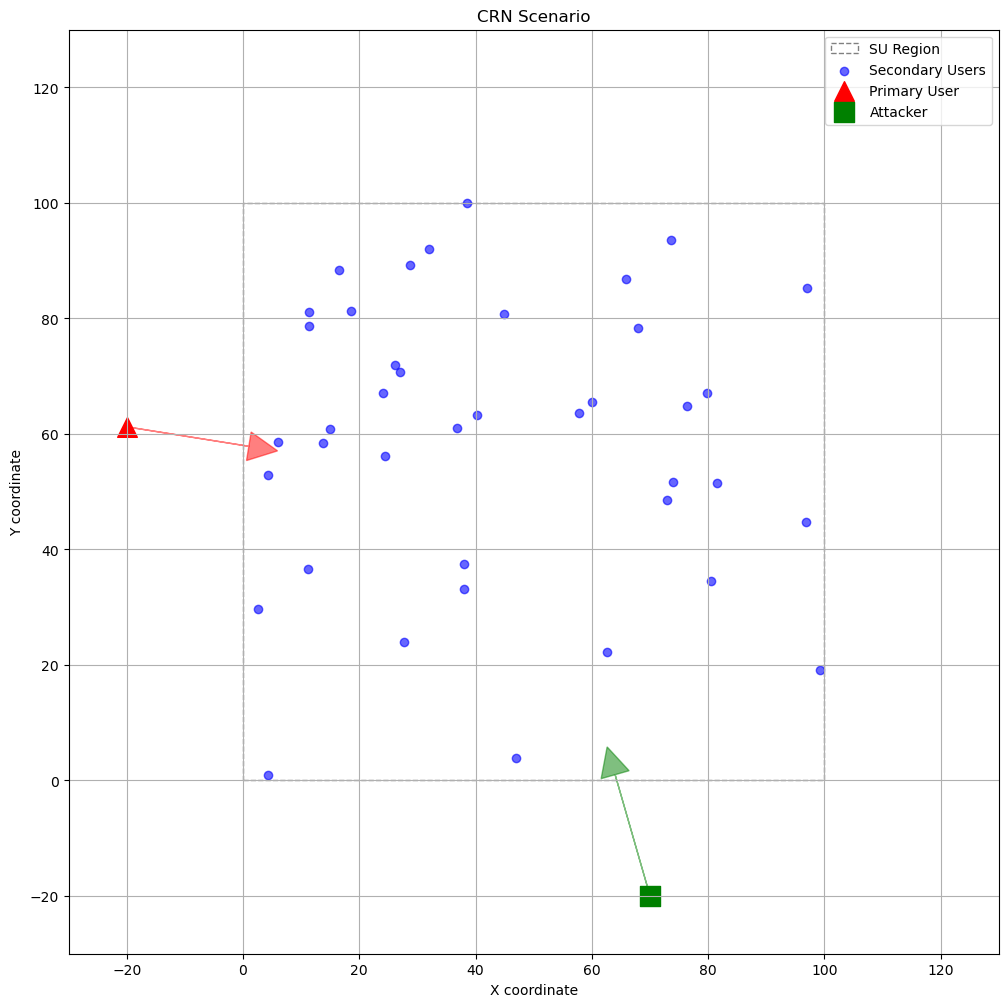

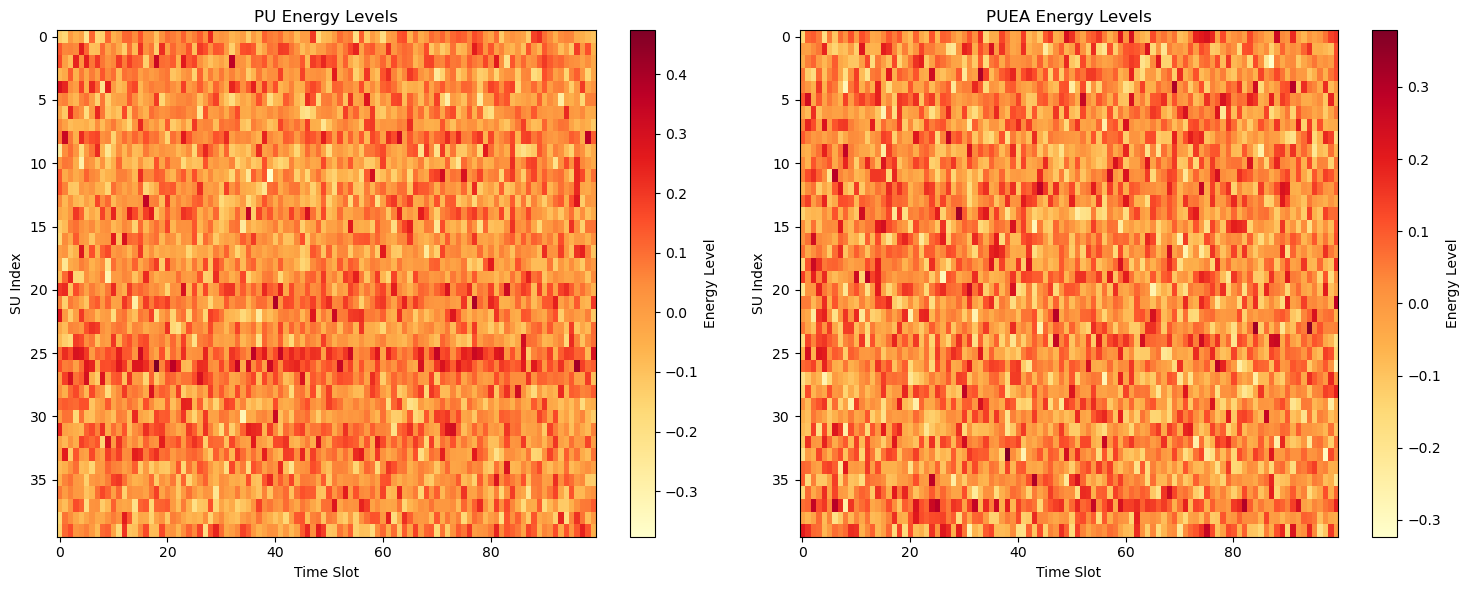


Statistical Features Comparison:
                      PU      PUEA
Mean            0.036536  0.017027
Median          0.035696  0.016836
Variance        0.011214  0.010258
Upper Quartile  0.107107  0.085222
Lower Quartile -0.035266 -0.051323


<Figure size 1000x600 with 0 Axes>

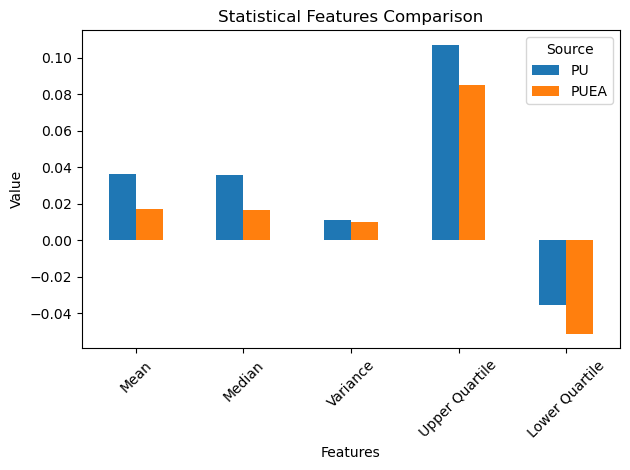

C:\Users\srish\AppData\Local\Temp\ipykernel_2324\2411187663.py:174: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['PU', 'PUEA'])


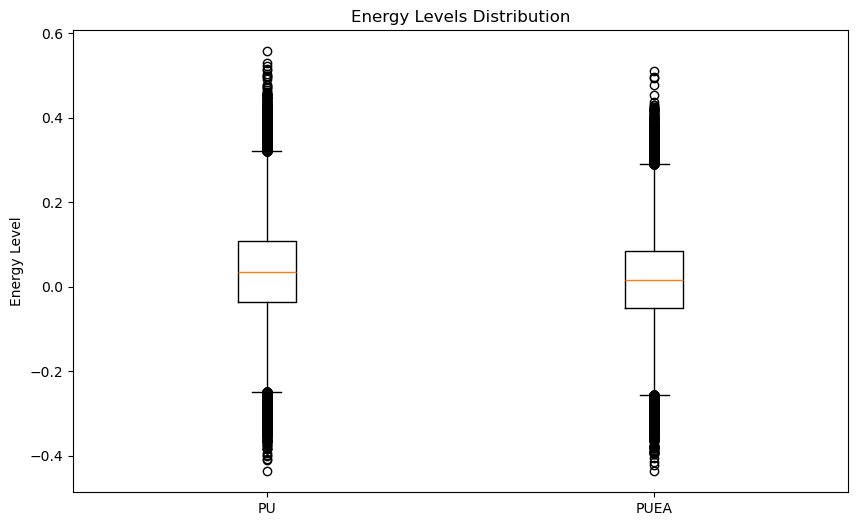


Confusion Matrix:
True Negatives (Genuine PU correctly identified): 1366
False Positives (Genuine PU incorrectly identified as attacker): 653
False Negatives (Attacker incorrectly identified as genuine PU): 686
True Positives (Attacker correctly identified): 1295

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.68      0.67      2019
         1.0       0.66      0.65      0.66      1981

    accuracy                           0.67      4000
   macro avg       0.67      0.67      0.67      4000
weighted avg       0.67      0.67      0.67      4000



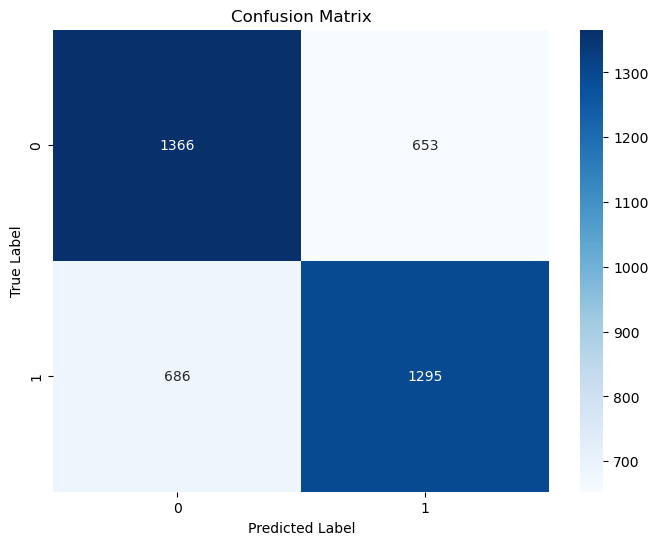

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

class CRNSimulation:
    def __init__(self, num_sus=40, num_slots=10000, region_size=100):
        self.num_sus = num_sus
        self.num_slots = num_slots
        self.region_size = region_size
        self.su_locations = None
        self.pu_location = None
        self.attacker_location = None
        self.pu_energy_levels = None
        self.attacker_energy_levels = None
        
    def generate_locations(self, scenario='inside'):
        """Generate random locations for SUs, PU, and attacker"""
        # Generate SU locations
        self.su_locations = np.random.uniform(0, self.region_size, size=(self.num_sus, 2))
        
        if scenario == 'inside':
            # PU and attacker inside the region
            self.pu_location = np.random.uniform(0, self.region_size, size=2)
            self.attacker_location = np.random.uniform(0, self.region_size, size=2)
        else:
            # PU and attacker outside the region
            # Randomly place PU and attacker outside but near the region
            sides = ['top', 'bottom', 'left', 'right']
            pu_side = np.random.choice(sides)
            attacker_side = np.random.choice([s for s in sides if s != pu_side])
            
            if pu_side == 'top':
                self.pu_location = np.array([np.random.uniform(0, self.region_size), self.region_size * 1.2])
            elif pu_side == 'bottom':
                self.pu_location = np.array([np.random.uniform(0, self.region_size), -self.region_size * 0.2])
            elif pu_side == 'left':
                self.pu_location = np.array([-self.region_size * 0.2, np.random.uniform(0, self.region_size)])
            else:  # right
                self.pu_location = np.array([self.region_size * 1.2, np.random.uniform(0, self.region_size)])
                
            if attacker_side == 'top':
                self.attacker_location = np.array([np.random.uniform(0, self.region_size), self.region_size * 1.2])
            elif attacker_side == 'bottom':
                self.attacker_location = np.array([np.random.uniform(0, self.region_size), -self.region_size * 0.2])
            elif attacker_side == 'left':
                self.attacker_location = np.array([-self.region_size * 0.2, np.random.uniform(0, self.region_size)])
            else:  # right
                self.attacker_location = np.array([self.region_size * 1.2, np.random.uniform(0, self.region_size)])
    
    def plot_scenario(self):
        """Plot the current scenario with enhanced visualization"""
        plt.figure(figsize=(12, 12))
        
        # Plot region boundary
        rect = plt.Rectangle((0, 0), self.region_size, self.region_size, 
                           fill=False, color='gray', linestyle='--', label='SU Region')
        plt.gca().add_patch(rect)
        
        # Plot SUs, PU, and Attacker
        plt.scatter(self.su_locations[:, 0], self.su_locations[:, 1], 
                   c='blue', label='Secondary Users', alpha=0.6)
        plt.scatter(self.pu_location[0], self.pu_location[1], 
                   c='red', marker='^', s=200, label='Primary User')
        plt.scatter(self.attacker_location[0], self.attacker_location[1], 
                   c='green', marker='s', s=200, label='Attacker')
        
        # Add arrows from PU and Attacker to the region
        center = np.array([self.region_size/2, self.region_size/2])
        plt.arrow(self.pu_location[0], self.pu_location[1], 
                 (center[0] - self.pu_location[0])*0.3, 
                 (center[1] - self.pu_location[1])*0.3,
                 head_width=5, head_length=5, fc='red', ec='red', alpha=0.5)
        plt.arrow(self.attacker_location[0], self.attacker_location[1],
                 (center[0] - self.attacker_location[0])*0.3,
                 (center[1] - self.attacker_location[1])*0.3,
                 head_width=5, head_length=5, fc='green', ec='green', alpha=0.5)
        
        plt.xlim(-self.region_size*0.3, self.region_size*1.3)
        plt.ylim(-self.region_size*0.3, self.region_size*1.3)
        plt.grid(True)
        plt.legend()
        plt.title('CRN Scenario')
        plt.xlabel('X coordinate')
        plt.ylabel('Y coordinate')
        plt.show()
    
    def calculate_distance(self, point1, point2):
        """Calculate Euclidean distance between two points"""
        return np.sqrt(np.sum((point1 - point2) ** 2))
    
    def generate_energy_levels(self, source_location, power=100, noise_std=0.1):
        """Generate energy levels received at SUs from a source"""
        energy_levels = np.zeros((self.num_slots, self.num_sus))
        
        for slot in range(self.num_slots):
            for su in range(self.num_sus):
                distance = self.calculate_distance(source_location, self.su_locations[su])
                # Path loss model with random noise
                received_power = power / (distance ** 2)
                noise = np.random.normal(0, noise_std)
                energy_levels[slot, su] = received_power + noise
        
        return energy_levels
    
    def visualize_energy_levels(self, time_slots=100):
        """Visualize energy levels for first few time slots"""
        plt.figure(figsize=(15, 6))
        
        # Plot PU energy levels
        plt.subplot(1, 2, 1)
        plt.imshow(self.pu_energy_levels[:time_slots].T, aspect='auto', cmap='YlOrRd')
        plt.colorbar(label='Energy Level')
        plt.title('PU Energy Levels')
        plt.xlabel('Time Slot')
        plt.ylabel('SU Index')
        
        # Plot Attacker energy levels
        plt.subplot(1, 2, 2)
        plt.imshow(self.attacker_energy_levels[:time_slots].T, aspect='auto', cmap='YlOrRd')
        plt.colorbar(label='Energy Level')
        plt.title('PUEA Energy Levels')
        plt.xlabel('Time Slot')
        plt.ylabel('SU Index')
        
        plt.tight_layout()
        plt.show()
    
    def display_statistical_features(self):
        """Display statistical features for both PU and PUEA energy levels"""
        # Calculate statistics for PU
        pu_stats = {
            'Mean': np.mean(self.pu_energy_levels),
            'Median': np.median(self.pu_energy_levels),
            'Variance': np.var(self.pu_energy_levels),
            'Upper Quartile': np.percentile(self.pu_energy_levels, 75),
            'Lower Quartile': np.percentile(self.pu_energy_levels, 25)
        }
        
        # Calculate statistics for Attacker
        attacker_stats = {
            'Mean': np.mean(self.attacker_energy_levels),
            'Median': np.median(self.attacker_energy_levels),
            'Variance': np.var(self.attacker_energy_levels),
            'Upper Quartile': np.percentile(self.attacker_energy_levels, 75),
            'Lower Quartile': np.percentile(self.attacker_energy_levels, 25)
        }
        
        # Create DataFrame for comparison
        stats_df = pd.DataFrame({
            'PU': pu_stats,
            'PUEA': attacker_stats
        })
        
        print("\nStatistical Features Comparison:")
        print(stats_df)
        
        # Visualize the statistics
        plt.figure(figsize=(10, 6))
        stats_df.plot(kind='bar')
        plt.title('Statistical Features Comparison')
        plt.xlabel('Features')
        plt.ylabel('Value')
        plt.legend(title='Source')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Box plots for distribution comparison
        plt.figure(figsize=(10, 6))
        data = [self.pu_energy_levels.flatten(), self.attacker_energy_levels.flatten()]
        plt.boxplot(data, labels=['PU', 'PUEA'])
        plt.title('Energy Levels Distribution')
        plt.ylabel('Energy Level')
        plt.show()
    
    def generate_dataset(self):
        """Generate training and testing datasets"""
        # Generate energy levels from PU (legitimate transmissions)
        self.pu_energy_levels = self.generate_energy_levels(self.pu_location)
        pu_features = self.extract_features(self.pu_energy_levels)
        pu_labels = np.zeros(len(pu_features))
        
        # Generate energy levels from attacker (PUEA)
        self.attacker_energy_levels = self.generate_energy_levels(self.attacker_location)
        attacker_features = self.extract_features(self.attacker_energy_levels)
        attacker_labels = np.ones(len(attacker_features))
        
        # Visualize energy levels and statistical features
        self.visualize_energy_levels()
        self.display_statistical_features()
        
        # Combine datasets
        X = np.vstack((pu_features, attacker_features))
        y = np.hstack((pu_labels, attacker_labels))
        
        return train_test_split(X, y, test_size=0.2, random_state=42)
    
    def extract_features(self, energy_levels):
        """Extract statistical features from energy levels"""
        features = np.zeros((len(energy_levels), 5))
        
        features[:, 0] = np.mean(energy_levels, axis=1)
        features[:, 1] = np.var(energy_levels, axis=1)
        features[:, 2] = np.median(energy_levels, axis=1)
        features[:, 3] = np.percentile(energy_levels, 75, axis=1)
        features[:, 4] = np.percentile(energy_levels, 25, axis=1)
        
        return features

    def evaluate_performance(self, y_true, y_pred):
        """Evaluate detection performance"""
        cm = confusion_matrix(y_true, y_pred)
        
        print("\nConfusion Matrix:")
        print(f"True Negatives (Genuine PU correctly identified): {cm[0,0]}")
        print(f"False Positives (Genuine PU incorrectly identified as attacker): {cm[0,1]}")
        print(f"False Negatives (Attacker incorrectly identified as genuine PU): {cm[1,0]}")
        print(f"True Positives (Attacker correctly identified): {cm[1,1]}")
        
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

# Example usage
if __name__ == "__main__":
    # Create simulation instance
    sim = CRNSimulation(num_sus=40, num_slots=10000, region_size=100)
    
    # Scenario with PU and attacker outside the region
    print("Scenario: PU and attacker outside the region")
    sim.generate_locations(scenario='outside')
    sim.plot_scenario()
    
    # Generate dataset and evaluate
    X_train, X_test, y_train, y_test = sim.generate_dataset()
    
    # Train and evaluate classifier
    from sklearn.tree import DecisionTreeClassifier
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    # Evaluate performance
    sim.evaluate_performance(y_test, y_pred)